# [IEEE Fraud Detection Competition](https://www.kaggle.com/c/ieee-fraud-detection/overview)

From the [competition overview](https://www.kaggle.com/c/ieee-fraud-detection/overview):

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

## Goal: 
- Basic exploritory data analysis on the IEEE Fraud Detection dataset.
- Feature Engineering and Using LGBM to Make a Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# 1. Data

In the competition I am predicting the probability that an online transaction is fraudulent, as denoted by the binary target is Fraud.

The data is broken into two files identity and transaction, which can be joined by TransactionID. 

### 1.1 Read the data

In [2]:
%%time
# Transaction CSVs
train_transaction = pd.read_csv('./data/train_transaction.csv')
test_transaction = pd.read_csv('./data/test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('./data/train_identity.csv')
test_identity = pd.read_csv('./data/test_identity.csv')

# Sample Submissions
ss = pd.read_csv('./data/sample_submission.csv')

CPU times: user 24.5 s, sys: 5.64 s, total: 30.2 s
Wall time: 31 s


In [3]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# list(train_transaction.columns)
# list(train_identity.columns) - note "DeviceType" and "DeviceInfo"

In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### 1.2 Exam the link between transaction and identity data

In [7]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


24.4% of TransactionIDs in train (144233 / 590540) have an associated train_identity.  
28.0% of TransactionIDs in test (144233 / 590540) have an associated train_identity.

This indicates that not all transactions have corresponding identity information.

### 1.3 Data Split on "TransactionDT" (Time Series)

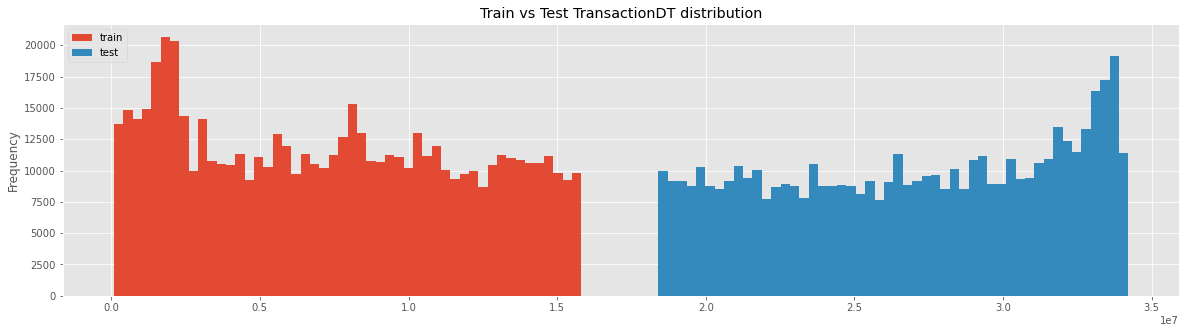

In [20]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(20, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

We can see that train and test data are split by transactionDT. The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

We will look into this more when reviewing differences in distribution of features between train and test.

### 1.4 Target Distribution

In [9]:
#Check class imbalance

train_transaction['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

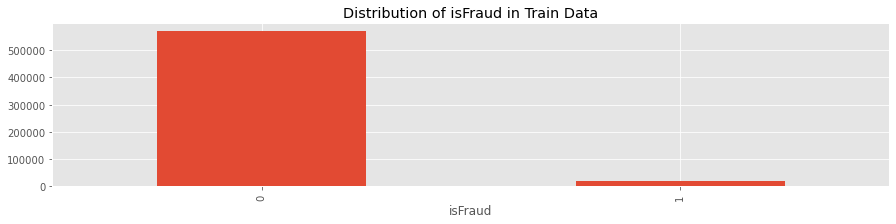

In [10]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='bar',
          title='Distribution of isFraud in Train Data',
          figsize=(15, 3))
plt.show()

Heavily imbalanced class (as expected in most fraud detection cases)

### 1.5 TransactionAmt

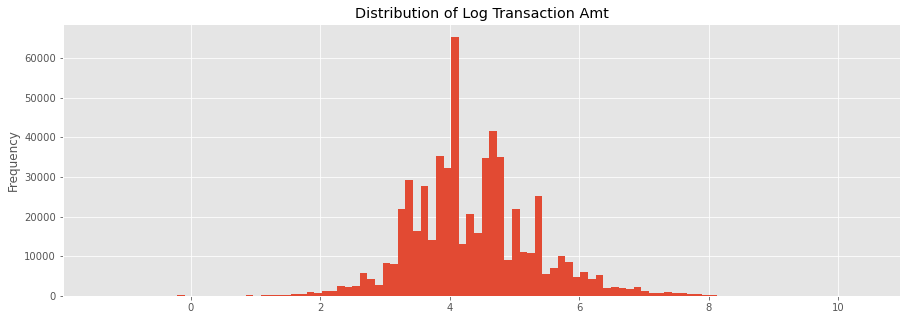

In [11]:
train_transaction.groupby("isFraud")["TransactionAmt"].apply(np.log).plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt');

In [12]:
train_transaction.groupby("isFraud")["TransactionAmt"].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,569877.0,134.511665,239.395078,0.251,43.970,68.5,120.0,31937.391
1,20663.0,149.244779,232.212163,0.292,35.044,75.0,161.0,5191.000


Normal distribution in transaction amount with similar mean (with fraud tranx to be slightly higher) and std (fraud is slightly lower) between fraud and non-fruad transaction.  

Fraud transactions have been overlapped by non-fraud so let's look at them separately. 

The transaction amounts are heavily skewed in distribution so I will try using log transformation to make it conform to normal distribution. 

Note, because of the log transfrom, any values between 0 and 1 will appear to be negative.

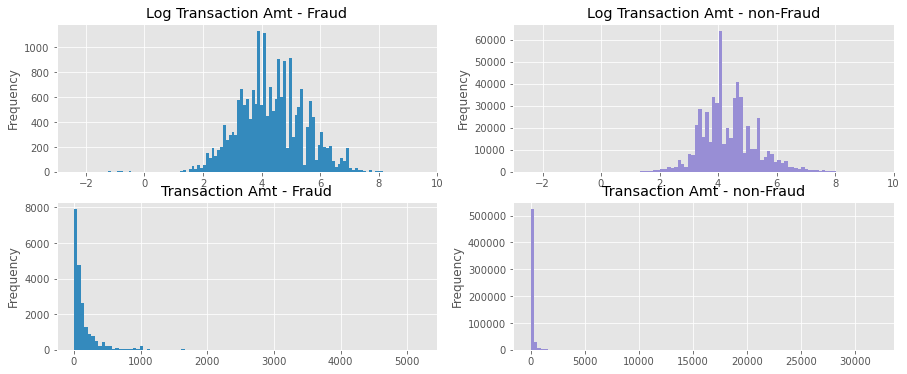

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))

train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(
    kind='hist',
    bins=100,
    title='Log Transaction Amt - Fraud',
    color=color_pal[1],
    xlim=(-3, 10),
    ax= ax1)

train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(
    kind='hist',
    bins=100,
    title='Log Transaction Amt - non-Fraud',
    color=color_pal[2],
    xlim=(-3, 10),
    ax= ax2)

train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].plot(
    kind='hist',
    bins=100,
    title='Transaction Amt - Fraud',
    color=color_pal[1],
    ax= ax3)

train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].plot(
    kind='hist',
    bins=100,
    title='Transaction Amt - non-Fraud',
    color=color_pal[2],
    ax= ax4)
plt.show()

### 1.7 Categorical Features - Transaction


As described in project page [here](https://www.kaggle.com/c/ieee-fraud-detection/data), the following features are categorical. 

- ProductCD
- P_emaildomain
- R_emaildomain
- card1 - card6
- addr1, addr2
- M1 - M9

Let's take a look at these now.

#### 1.7.1 ProductCD

We don't exactly know what each values stands for so we will look at its relation with target value. 

In [22]:
train_transaction["ProductCD"].value_counts(normalize=True)

W    0.744522
C    0.116028
R    0.063838
H    0.055922
S    0.019690
Name: ProductCD, dtype: float64

In [21]:
train_transaction.loc[train_transaction['isFraud']==1]["ProductCD"].value_counts()

W    430701
C     60511
R     36273
H     31450
S     10942
Name: ProductCD, dtype: int64

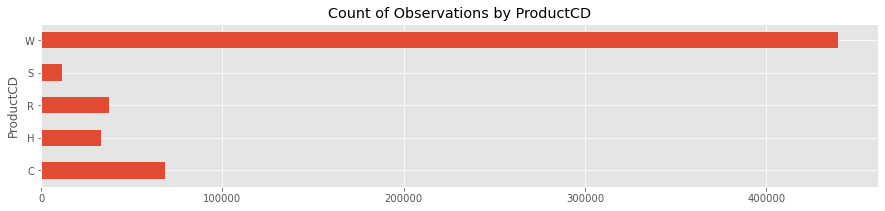

In [16]:
train_transaction.groupby('ProductCD')['TransactionID'].count().sort_index().plot(
    kind='barh',
    figsize=(15, 3),
    title='Count of Observations by ProductCD')
plt.show()

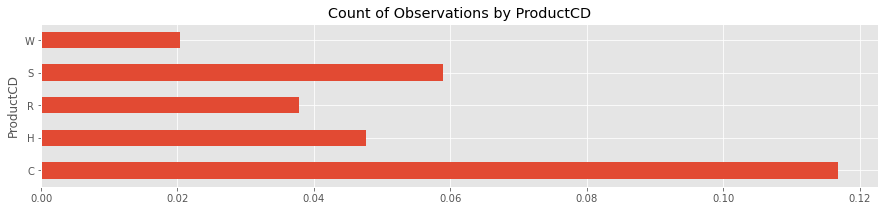

In [24]:
train_transaction.groupby('ProductCD')['isFraud'].mean().sort_index().plot(
    kind='barh',
    figsize=(15, 3),
    title='Count of Observations by ProductCD')
plt.show()

What we can see here is that transactions with ProductCD with "C" and "S" have higher % of fraud target. 

#### 1.7.2 Emaildomain  'P_emaildomain' and 'R_emaildomain'

In [30]:
[col for col in train_transaction.columns if 'email' in col]

['P_emaildomain', 'R_emaildomain']

In [52]:
p_email_domain = train_transaction['P_emaildomain'].unique()
p_email_domain

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [51]:
r_email_domain = train_transaction['R_emaildomain'].unique()
r_email_domain

array([nan, 'gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com',
       'charter.net', 'prodigy.net.mx', 'comcast.net', 'live.com.mx',
       'icloud.com', 'yahoo.com', 'aol.com', 'juno.com', 'att.net',
       'verizon.net', 'yahoo.com.mx', 'bellsouth.net', 'servicios-ta.com',
       'ymail.com', 'hotmail.es', 'msn.com', 'optonline.net', 'live.com',
       'gmx.de', 'aim.com', 'mail.com', 'me.com', 'outlook.es', 'cox.net',
       'earthlink.net', 'embarqmail.com', 'web.de', 'sbcglobal.net',
       'scranton.edu', 'mac.com', 'twc.com', 'roadrunner.com', 'yahoo.fr',
       'yahoo.de', 'yahoo.es', 'frontiernet.net', 'gmail', 'live.fr',
       'q.com', 'yahoo.co.uk', 'windstream.net', 'suddenlink.net',
       'hotmail.fr', 'ptd.net', 'hotmail.de', 'frontier.com',
       'cfl.rr.com', 'hotmail.co.uk', 'netzero.com', 'netzero.net',
       'yahoo.co.jp', 'rocketmail.com', 'centurylink.net',
       'protonmail.com', 'cableone.net', 'sc.rr.com'], dtype=object)

There are duplicate values with different spelling so I will create a dictionary to map the values and clean the data of these two features.

In [58]:
combined_unique_email = np.concatenate([p_email_domain, r_email_domain[~np.isin(r_email_domain,p_email_domain)]])
combined_unique_email

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp', nan,
       'scranton.edu'], dtype=object)

In [86]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', \
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', \
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', \
          'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', \
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', \
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', \
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', \
          'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', \
          'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', \
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', \
          'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', \
          'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', \
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', \
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', \
          'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', \
          'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [87]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train_transaction[c + '_bin'] = train_transaction[c].map(emails)
    test_transaction[c + '_bin'] = test_transaction[c].map(emails)
    
    train_transaction[c + '_suffix'] = train_transaction[c].map(lambda x: str(x).split('.')[-1])
    test_transaction[c + '_suffix'] = test_transaction[c].map(lambda x: str(x).split('.')[-1])
    
    train_transaction[c + '_suffix'] = train_transaction[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_transaction[c + '_suffix'] = test_transaction[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [89]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V334,V335,V336,V337,V338,V339,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,nan
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,google,com,NaN,nan
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,microsoft,com,NaN,nan
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,com,NaN,nan
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,google,com,NaN,nan


### 1.7.3 card1 - card6

In [105]:
card_cols = [col for col in train_transaction.columns if 'card' in col]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


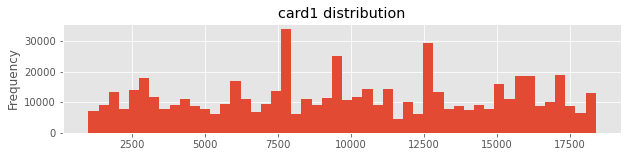

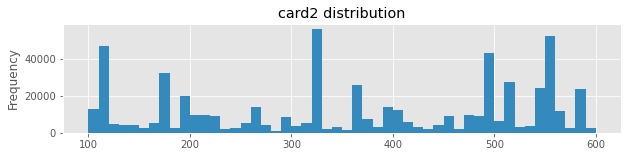

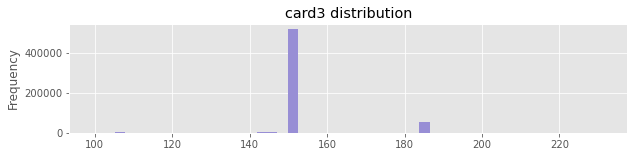

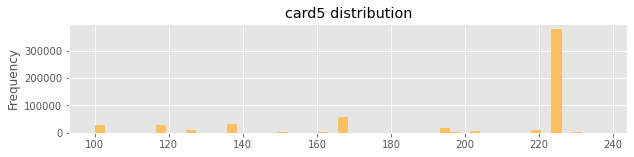

In [147]:
color_idx = 0
for col in card_cols:
    if train_transaction[col].dtype !='object':
        train_transaction[col].plot(kind='hist', bins=50, title=f'{col} distribution',
        color=color_pal[color_idx], figsize=(10, 2))
    plt.show()
    color_idx +=1

<Figure size 432x288 with 0 Axes>

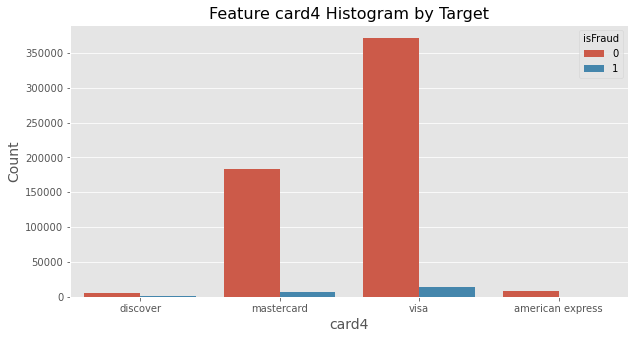

<Figure size 432x288 with 0 Axes>

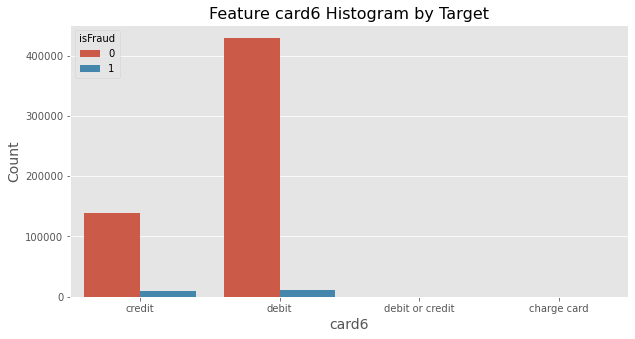

In [148]:
for col in card_cols:
    if train_transaction[col].dtype == 'object':
        plt.figure()
        fig, ax = plt.subplots(figsize=(10,5))
        sns.countplot(x=col, hue='isFraud', data=train_transaction)
    
        plt.ylabel('Count', fontsize=14)
        plt.xlabel(col, fontsize=14)
        plt.title(f'Feature {col} Histogram by Target', fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show();

Not seeing any particularly useful pattern between target groups.

### 1.7.4 addr1, addr2

Possibly representing difference addresses or region. 

In [155]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


<AxesSubplot:ylabel='Frequency'>

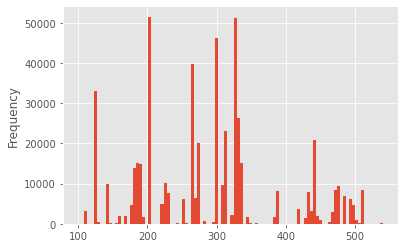

In [154]:
train_transaction.addr1.plot(kind='hist', bins=100)

In [162]:
len(train_transaction.addr1.unique())

333

"addr1" has 333 different values and the distribution is wide. 

<AxesSubplot:ylabel='Frequency'>

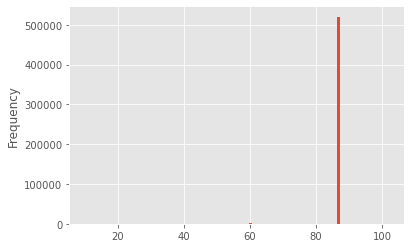

In [156]:
train_transaction.addr2.plot(kind='hist', bins=100)

In [161]:
len(train_transaction.addr2.unique())

75

In [168]:
train_transaction.addr2.value_counts(normalize=True, dropna=False)

87.0    0.881365
NaN     0.111264
60.0    0.005222
96.0    0.001080
32.0    0.000154
          ...   
22.0    0.000002
25.0    0.000002
75.0    0.000002
49.0    0.000002
77.0    0.000002
Name: addr2, Length: 75, dtype: float64

"addr2" has only 75 different values and 88% of them is 85. 11% is NaN. 

### 1.7.5 M1-M9

These features seem to be binary with an exception of "M4", which has values such as M2 and M0. 

In [174]:
m_cols = [c for c in train_transaction if c[0] == 'M']
train_transaction[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

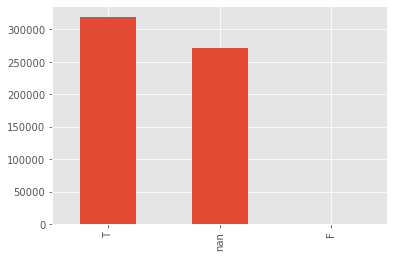

In [178]:
train_transaction.M1.value_counts(dropna=False).plot(kind="bar")

In [173]:
train_transaction.M2.value_counts(dropna=False, normalize=True)

T      0.483402
NaN    0.459071
F      0.057527
Name: M2, dtype: float64

In [175]:
train_transaction.M3.value_counts(dropna=False, normalize=True)

NaN    0.459071
T      0.426273
F      0.114656
Name: M3, dtype: float64

In [176]:
train_transaction.M4.value_counts(dropna=False, normalize=True)

NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: M4, dtype: float64